In [1]:
%matplotlib widget

In [227]:
import sys
sys.path.append('../../../')

import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
plt.style.use('ggplot')

from SeismicPro.seismicpro import Survey, SeismicDataset

In [3]:
sgy_path = 'data/test_g_coord.sgy'

In [4]:
survey = Survey(path=sgy_path, header_index=['GroupWaterDepth', 'SourceDatumElevation'],
                header_cols=['offset', 'GroupX', 'GroupY', 'SourceX', 'SourceY',
                             'FieldRecord', 'TraceNumber', 'CDP_X', 'CDP_Y', 'INLINE_3D', 'CROSSLINE_3D'])

Trace headers loaded:   0%|          | 0/58706100 [00:00<?, ?it/s]

In [5]:
survey.info()

Survey path:               /notebooks/anke/anke_/processing/data/test_g_coord.sgy
Survey name:               test_g_coord
Survey size:               188.298 GB

Indexed by:                GroupWaterDepth, SourceDatumElevation
Number of gathers:         30478
Number of traces:          58706100
Trace length:              801 samples
Sample rate:               2.0 ms
Times range:               [0.0 ms, 1600.0 ms]
Offsets range:             [5 m, 2000 m]


In [6]:
survey.headers.index.rename(names={'SourceDatumElevation': 'Recline', 'GroupWaterDepth': 'Shotline'}, inplace=True)

In [7]:
survey.headers

FieldRecord  TraceNumber  offset  SourceX  SourceY  GroupX  \
Shotline Recline                                                               
1131     4131           47223          791    1975   435712  6576388  435637   
         4131           47223          792    1975   435712  6576388  435688   
         4131           47223          793    1975   435712  6576388  435737   
         4131           47223          794    1975   435712  6576388  435787   
         4131           47223          790    1978   435712  6576388  435587   
...                       ...          ...     ...      ...      ...     ...   
1941     4791             591         2668    1983   476196  6605426  476371   
         4791             591         2660    1987   476196  6605426  475971   
         4791             591         2669    1987   476196  6605426  476421   
         4791             591         2659    1994   476196  6605426  475921   
         4791             591         2670    1994   476196  6605426  476471   

                   GroupY   CDP_X    CDP_Y  INLINE_3D  CROSSLINE_3D  \
Shotline Recline                                                      
1131     4131     6574414  435674  6575401        450           144   
         4131     6574414  435699  6575401        450           145   
         4131     6574414  435724  6575401        450           146   
         4131     6574414  435749  6575401        450           147   
         4131     6574414  435649  6575401        450           143   
...                   ...     ...      ...        ...           ...   
1941     4791     6607401  476283  6606413       1691          1769   
         4791     6607401  476083  6606413       1691          1761   
         4791     6607401  476308  6606413       1691          1770   
         4791     6607401  476058  6606413       1691          1760   
         4791     6607401  476333  6606413       1691          1771   

                  TRACE_SEQUENCE_FILE  
Shotline Recline                       
1131     4131                33500154  
         4131                33500155  
         4131                33500156  
         4131                33500157  
         4131                33500160  
...                               ...  
1941     4791                  382025  
         4791                  382026  
         4791                  382027  
         4791                  382034  
         4791                  382035  

[58706100 rows x 12 columns]

# Бины

In [8]:
lines_unique, lines_index, lines_counts = np.unique(survey.headers.index.to_numpy(), return_index=True, return_counts=True)

num_gathers = len(lines_unique)
num_gathers

redundant_traces = np.empty(len(survey.headers), dtype=np.int32)
gather_stats = np.empty(num_gathers, dtype=int)

In [153]:
groupped = survey.headers.groupby(level=[0, 1])[["INLINE_3D", "CROSSLINE_3D"]]

In [157]:
groupped.agg(["size", "unique"])

INLINE_3D                                                     \
                      size                                             unique   
Shotline Recline                                                                
1131     4131           94                               [450, 449, 448, 447]   
         4137          363  [462, 461, 460, 459, 458, 457, 456, 455, 454, ...   
         4143          716  [474, 473, 472, 471, 470, 469, 468, 467, 466, ...   
         4149         1124  [486, 485, 484, 483, 482, 481, 480, 479, 478, ...   
         4155         1566  [498, 497, 496, 495, 494, 493, 492, 491, 490, ...   
...                    ...                                                ...   
1941     4767         1004  [1672, 1671, 1670, 1669, 1668, 1667, 1666, 166...   
         4773          905  [1678, 1677, 1676, 1675, 1674, 1673, 1672, 167...   
         4779          752  [1684, 1683, 1682, 1681, 1680, 1679, 1678, 167...   
         4785          472  [1690, 1689, 1688, 1687, 1686, 1685, 1684, 168...   
         4791          170               [1696, 1695, 1694, 1693, 1692, 1691]   

                 CROSSLINE_3D  \
                         size   
Shotline Recline                
1131     4131              94   
         4137             363   
         4143             716   
         4149            1124   
         4155            1566   
...                       ...   
1941     4767            1004   
         4773             905   
         4779             752   
         4785             472   
         4791             170   

                                                                     
                                                             unique  
Shotline Recline                                                     
1131     4131     [144, 145, 146, 147, 143, 148, 142, 149, 141, ...  
         4137     [145, 146, 144, 147, 143, 148, 142, 149, 141, ...  
         4143     [145, 146, 144, 147, 143, 148, 142, 149, 141, ...  
         4149     [145, 144, 146, 147, 143, 148, 142, 149, 141, ...  
         4155     [145, 146, 144, 147, 143, 148, 142, 149, 141, ...  
...                                                             ...  
1941     4767     [1765, 1766, 1764, 1767, 1763, 1768, 1762, 176...  
         4773     [1765, 1766, 1764, 1767, 1763, 1768, 1762, 176...  
         4779     [1766, 1765, 1764, 1767, 1763, 1768, 1762, 176...  
         4785     [1765, 1766, 1764, 1767, 1763, 1768, 1762, 176...  
         4791     [1765, 1766, 1767, 1764, 1763, 1768, 1762, 176...  

[30478 rows x 4 columns]

In [9]:
for idx in tqdm(range(num_gathers)):
    gather_field = survey.headers.iloc[lines_index[idx]: lines_index[idx] + lines_counts[idx]]
    coordinates = gather_field.iloc[:, 9:11]   # inline, crossline
    coordinates_unique = np.unique(coordinates, axis=0)
    num_coords = len(coordinates_unique)
    num_traces = gather_field.iloc[:, 11].size # trace_sequence_file
    redundant_traces[lines_index[idx]: lines_index[idx] + lines_counts[idx]] = num_traces - num_coords
    gather_stats[idx] = num_traces - num_coords

100%|██████████| 30478/30478 [00:31<00:00, 953.19it/s] 


In [10]:
survey.headers['Redundant_traces'] = redundant_traces

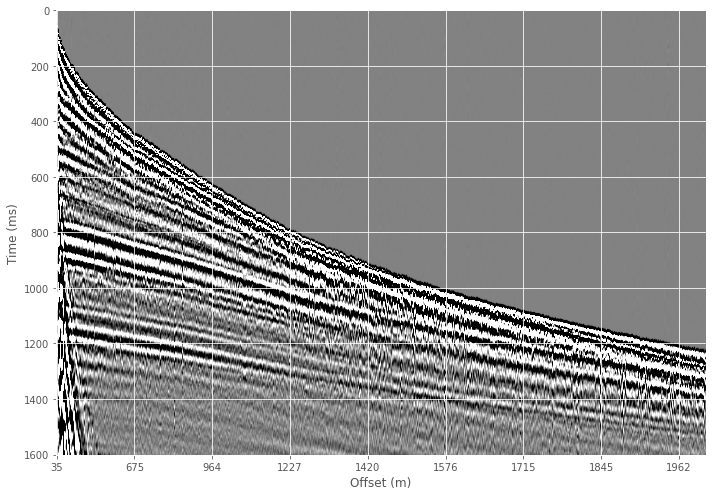

In [174]:
%matplotlib inline
g = survey.get_gather(survey.indices[gather_stats.argmax()])
g.sort(by="offset").plot()

In [176]:
g.shape

(4172, 801)

In [175]:
g.headers

FieldRecord  TraceNumber  offset  SourceX  SourceY  GroupX  \
Shotline Recline                                                               
1773     4623            3993         1656      35   467799  6599029  467774   
         4623            3993         1657      35   467799  6599029  467824   
         4623            4175         1800      35   467799  6598979  467774   
         4623            4175         1801      35   467799  6598979  467824   
         4623            3992         1656      79   467799  6599079  467774   
...                       ...          ...     ...      ...      ...     ...   
         4623            5563         2496    1995   467800  6597430  466575   
         4623            5886         2675    1995   467799  6597080  468324   
         4623            4951         1984    1999   467806  6598653  469774   
         4623            3255          918    2000   467799  6600778  466875   
         4623            3255          955    2000   467799  6600778  468724   

                   GroupY   CDP_X    CDP_Y  INLINE_3D  CROSSLINE_3D  \
Shotline Recline                                                      
1773     4623     6599004  467786  6599016       1395          1429   
         4623     6599004  467811  6599016       1395          1430   
         4623     6599004  467786  6598991       1394          1429   
         4623     6599004  467811  6598991       1394          1430   
         4623     6599004  467786  6599041       1396          1429   
...                   ...     ...      ...        ...           ...   
         4623     6599004  467187  6598216       1363          1405   
         4623     6599004  468061  6598041       1356          1440   
         4623     6599004  468786  6598816       1387          1469   
         4623     6599004  467337  6599891       1430          1411   
         4623     6599004  468261  6599891       1430          1448   

                  TRACE_SEQUENCE_FILE  Redundant_traces  FirstBreak  
Shotline Recline                                                     
1773     4623                 2982948               154        58.0  
         4623                 2982949               154        62.0  
         4623                 3127043               154        56.0  
         4623                 3127044               154        58.0  
         4623                 2982112               154        82.0  
...                               ...               ...         ...  
         4623                 4187016               154      1264.0  
         4623                 4440731               154      1240.0  
         4623                 3732947               154      1264.0  
         4623                 2393891               154      1242.0  
         4623                 2393892               154      1246.0  

[4172 rows x 14 columns]

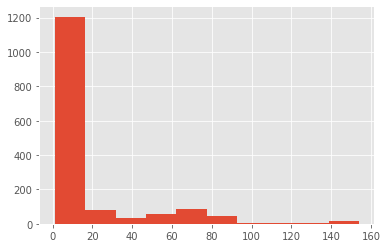

In [11]:
%matplotlib inline
plt.hist(gather_stats[gather_stats > 0]);

In [35]:
non_zeros = len(gather_stats[gather_stats != 0])
print(f'Fraction of gathers with redundant traces: {(non_zeros / num_gathers):.3f}\n'
      f'Number of gathers with redundant traces: {non_zeros}\n'
      f'Number of gathers: {num_gathers}\n'
      f'Fraction of redundant traces: {(gather_stats.sum() / len(survey.headers)):.5f}\n'
      f'Number of redundant traces: {gather_stats.sum()}\n'
      f'Number of traces: {len(survey.headers)}\n'
      f'Max redundant traces in gather: {gather_stats.max()}\n'
      f'Mean redundant traces in gather: {(gather_stats.mean()):.3f}\n'
     )

Fraction of gathers with redundant traces: 0.050
Number of gathers with redundant traces: 1535
Number of gathers: 30478
Fraction of redundant traces: 0.00041
Number of redundant traces: 24202
Number of traces: 58719618
Max redundant traces in gather: 154
Mean redundant traces in gather: 0.794



# Кликалка

In [13]:
survey.load_first_breaks(path='data/picking_v3_max_1d', inplace=True)

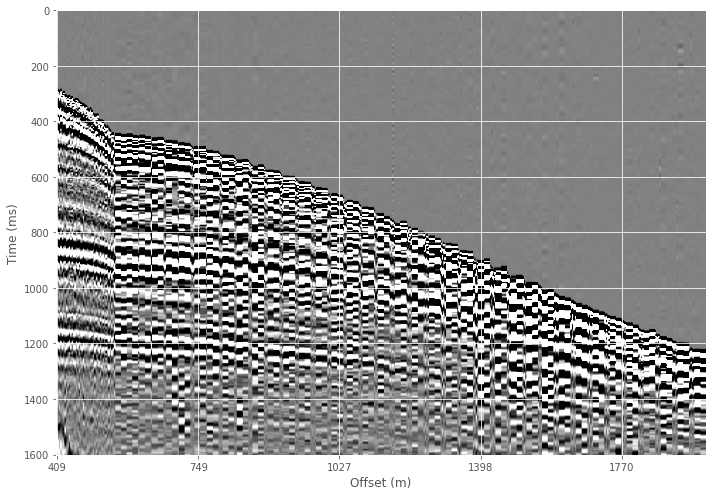

In [186]:
gather.filter(lambda x: gather.headers[["INLINE_3D", "CROSSLINE_3D"]].duplicated(keep=False), cols="offset").plot()

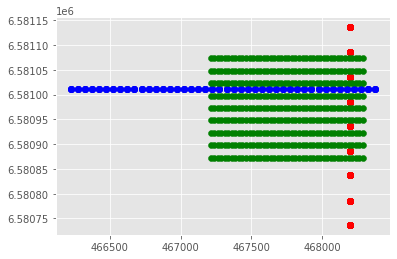

In [195]:
%matplotlib inline
# gather = g
plt.scatter(*gather[["SourceX", "SourceY"]].T, c="red")
plt.scatter(*gather[["GroupX", "GroupY"]].T, c="blue")
plt.scatter(*gather[["CDP_X", "CDP_Y"]].T, c="green")

In [105]:
len(gather.headers)

5027

In [191]:
gather = survey.sample_gather()
q_01, q_99 = gather.get_quantile(0.1), gather.get_quantile(0.99)

crossline_min, crossline_max = gather['CROSSLINE_3D'].min(), gather['CROSSLINE_3D'].max()
inline_min, inline_max = gather['INLINE_3D'].min(), gather['INLINE_3D'].max()

gather_3d = np.zeros((crossline_max + 1, inline_max + 1, len(gather.samples)))

for i, (crossline, inline) in enumerate(gather[['CROSSLINE_3D', 'INLINE_3D']]):
    gather_3d[crossline, inline] = gather.data[i]

volume = gather_3d[crossline_min: crossline_max + 1, inline_min: inline_max + 1, :]

In [192]:
first_breaks_3d = np.zeros((crossline_max + 1, inline_max + 1, 1))
for i, (crossline, inline) in enumerate(gather[['CROSSLINE_3D', 'INLINE_3D']]):
    first_breaks_3d[crossline, inline] = gather['FirstBreak'][i]

first_breaks_3d = first_breaks_3d[crossline_min: crossline_max + 1, inline_min: inline_max + 1, :] / 2

In [108]:
def remove_keymap_conflicts(new_keys_set):
    for prop in plt.rcParams:
        if prop.startswith('keymap.'):
            keys = plt.rcParams[prop]
            remove_list = set(keys) & new_keys_set
            for key in remove_list:
                keys.remove(key)

In [147]:
def gather_slice_viewer(volume, step=1, sample_rate=2, init_index=0, 
                        q_01=0, q_99=1, crosslines=None, inlines=None,
                        first_breaks=None):
    remove_keymap_conflicts({'j', 'k', 'n'})
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.volume = volume
    ax.sample_index = init_index
    ax.crossline_index = 0
    ax.inline_index = 0
    
    ax.sample_step = step
    ax.crossline_step = 5
    ax.inline_step = 5
    
    ax.current_view = 0
    ax.sample_rate = sample_rate
    ax.crosslines = crosslines
    ax.inlines = inlines
    ax.q_01 = q_01
    ax.q_99 = q_99
    ax.current_scatter = None
    
    ax.first_breaks = None
    if first_breaks is not None:
        ax.first_breaks = get_side_breaks(ax, first_breaks)
        
    ax.side_volume = get_side_volume(ax)
    draw_sample_view(ax)
    fig.canvas.draw()
    fig.canvas.mpl_connect('key_press_event', process_key)
    

def empty_scatter(ax):
    if ax.current_scatter is not None:
        ax.current_scatter.remove()
    
def get_side_volume(ax):
    side_volume = np.zeros((ax.volume.shape[0] * 5, ax.volume.shape[1] * 5, ax.volume.shape[2]), dtype=np.float32)
    for i in range(5):
        side_volume[i::5, i::5, :] = volume
    return side_volume
    
def get_side_breaks(ax, first_breaks):
    side_first_breaks = np.zeros((first_breaks.shape[0] * 5, first_breaks.shape[1] * 5, 1), dtype=np.float32)
    for i in range(5):
        side_first_breaks[i::5, i::5, :] = first_breaks
    return side_first_breaks
    
def draw_sample_view(ax):
    ax.set_xticks(range(0, ax.volume.shape[0], 20), labels=ax.crosslines[::20])
    ax.set_xlabel('Crossline')
    ax.set_yticks(range(0, ax.volume.shape[1], 20), labels=ax.inlines[::20])
    ax.set_ylabel('Inline')
    ax.set_title(f'Sample: {ax.sample_index * ax.sample_rate}')
    ax.imshow(ax.volume[:, :, ax.sample_index], vmin=ax.q_01, vmax=ax.q_99, cmap=plt.cm.Greys_r, interpolation='bilinear')
    
def draw_crossline_view(ax): 
    ax.set_xticks(range(0, ax.side_volume.shape[1], 100), labels=ax.inlines[::20])
    ax.set_xlabel('Inline')
    ax.set_yticks(range(0, ax.side_volume.shape[2], 100), labels=range(0, ax.side_volume.shape[2] * 2, 200))
    ax.set_ylabel('Sample')
    ax.set_title(f'Crossline: {ax.crosslines[0]}')
    ax.imshow(ax.side_volume[ax.crossline_index, :, :].T, vmin=ax.q_01, vmax=ax.q_99, cmap=plt.cm.Greys_r, interpolation='bilinear')
    if ax.first_breaks is not None:
        ax.current_scatter = ax.scatter(x=np.arange(0, ax.volume.shape[1] * 5), y=ax.first_breaks[ax.crossline_index * 5, :, :], label='first_breaks')
        ax.legend()
        
def draw_inline_view(ax):
    ax.set_xticks(range(0, ax.side_volume.shape[0], 100), labels=ax.crosslines[::20])
    ax.set_xlabel('Crossline')
    ax.set_yticks(range(0, ax.side_volume.shape[2], 100), labels=range(0, ax.side_volume.shape[2] * 2, 200))
    ax.set_ylabel('Sample')
    ax.set_title(f'Inline: {ax.inlines[0]}')
    ax.imshow(ax.side_volume[:, ax.inline_index, :].T, vmin=ax.q_01, vmax=ax.q_99, cmap=plt.cm.Greys_r, interpolation='bilinear')
    if ax.first_breaks is not None:
        ax.current_scatter = ax.scatter(x=np.arange(0, ax.volume.shape[0] * 5), y=ax.first_breaks[:, ax.inline_index * 5, :], label='first_breaks')
        ax.legend()
    
def process_key(event):
    fig = event.canvas.figure
    ax = fig.axes[0]
    empty_scatter(ax)
    if event.key == 'n': 
            redraw(ax)
            fig.canvas.draw()

    if ax.current_view == 0:
        if event.key == 'j':
            previous_sample(ax)
        elif event.key == 'k':
            next_sample(ax)
    elif ax.current_view == 1:
        if event.key == 'j':
            previous_crossline(ax)
        elif event.key == 'k':
            next_crossline(ax)
    elif ax.current_view == 2:
        if event.key == 'j':
            previous_inline(ax)
        elif event.key == 'k':
            next_inline(ax)
    else:
        raise ValueError()
    fig.canvas.draw()
    
def redraw(ax):
    if ax.current_view == 0:
        draw_crossline_view(ax)
    elif ax.current_view == 1:
        draw_inline_view(ax)
    else:
        draw_sample_view(ax)
    ax.current_view = (ax.current_view + 1) % 3
    fig.canvas.draw()
    
def previous_sample(ax):
    ax.sample_index = (ax.sample_index - ax.sample_step) % ax.volume.shape[2]  
    ax.images[0].set_array(ax.volume[:, :, ax.sample_index])
    ax.set_title(f'Sample: {ax.sample_index * ax.sample_rate}')

def next_sample(ax):
    ax.sample_index = (ax.sample_index + ax.sample_step) % ax.volume.shape[2]
    ax.images[0].set_array(ax.volume[:, :, ax.sample_index])
    ax.set_title(f'Sample: {ax.sample_index * ax.sample_rate}')
    
def previous_crossline(ax):
    ax.crossline_index = (ax.crossline_index - ax.crossline_step) % ax.volume.shape[0]  
    ax.images[1].set_array(ax.side_volume[ax.crossline_index * 5, :, :].T)
    ax.set_title(f'Crossline: {ax.crosslines[ax.crossline_index]}')
    if ax.first_breaks is not None:
        ax.current_scatter = ax.scatter(x=np.arange(0, ax.volume.shape[1] * 5), y=ax.first_breaks[ax.crossline_index * 5, :, :], label='first_breaks')
        ax.legend()
        
def next_crossline(ax):
    ax.crossline_index = (ax.crossline_index + ax.crossline_step) % ax.volume.shape[0]  
    ax.images[1].set_array(ax.side_volume[ax.crossline_index * 5, :, :].T)
    ax.set_title(f'Crossline: {ax.crosslines[ax.crossline_index]}')
    if ax.first_breaks is not None:
        ax.current_scatter = ax.scatter(x=np.arange(0, ax.volume.shape[1] * 5), y=ax.first_breaks[ax.crossline_index * 5, :, :], label='first_breaks')
        ax.legend()
        
def previous_inline(ax):
    ax.inline_index = (ax.inline_index - ax.inline_step) % ax.volume.shape[1]  
    ax.images[2].set_array(ax.side_volume[:, ax.inline_index * 5, :].T)
    ax.set_title(f'Inline: {ax.inlines[ax.inline_index]}')
    if ax.first_breaks is not None:
        ax.current_scatter = ax.scatter(x=np.arange(0, ax.volume.shape[0] * 5), y=ax.first_breaks[:, ax.inline_index * 5, :], label='first_breaks')
        ax.legend()

def next_inline(ax):
    ax.inline_index = (ax.inline_index + ax.inline_step) % ax.volume.shape[1]  
    ax.images[2].set_array(ax.side_volume[:, ax.inline_index * 5, :].T)
    ax.set_title(f'Inline: {ax.inlines[ax.inline_index]}')
    if ax.first_breaks is not None:
        ax.current_scatter = ax.scatter(x=np.arange(0, ax.volume.shape[0] * 5), y=ax.first_breaks[:, ax.inline_index * 5, :], label='first_breaks')
        ax.legend()

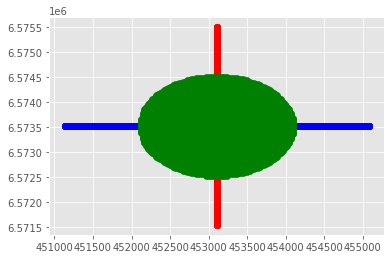

In [199]:
%matplotlib inline
gather = survey.sample_gather()
plt.scatter(*gather[["SourceX", "SourceY"]].T, c="red")
plt.scatter(*gather[["GroupX", "GroupY"]].T, c="blue")
plt.scatter(*gather[["CDP_X", "CDP_Y"]].T, c="green")

In [200]:
# gather = survey.sample_gather()
q_01, q_99 = gather.get_quantile(0.1), gather.get_quantile(0.99)

crossline_min, crossline_max = gather['CROSSLINE_3D'].min(), gather['CROSSLINE_3D'].max()
inline_min, inline_max = gather['INLINE_3D'].min(), gather['INLINE_3D'].max()

gather_3d = np.zeros((crossline_max + 1, inline_max + 1, len(gather.samples)))

for i, (crossline, inline) in enumerate(gather[['CROSSLINE_3D', 'INLINE_3D']]):
    gather_3d[crossline, inline] = gather.data[i]

volume = gather_3d[crossline_min: crossline_max + 1, inline_min: inline_max + 1, :]

first_breaks_3d = np.zeros((crossline_max + 1, inline_max + 1, 1))
for i, (crossline, inline) in enumerate(gather[['CROSSLINE_3D', 'INLINE_3D']]):
    first_breaks_3d[crossline, inline] = gather['FirstBreak'][i]

first_breaks_3d = first_breaks_3d[crossline_min: crossline_max + 1, inline_min: inline_max + 1, :] / 2

crossline_unique = np.unique(gather["CROSSLINE_3D"])
inline_unique = np.unique(gather["INLINE_3D"])

'k': next slice 
'j': prev slice
'n': next projection

In [220]:
%%time
sur_res = survey.reindex(["FieldRecord", "INLINE_3D"])

CPU times: user 10.9 s, sys: 5.59 s, total: 16.5 s
Wall time: 16.5 s


In [226]:
%%time
sur_res2 = survey.reindex(["FieldRecord", "CROSSLINE_3D"])

CPU times: user 20 s, sys: 7.12 s, total: 27.2 s
Wall time: 27.2 s


In [233]:
sur_res2.headers.index.names = ['FieldRecord', 'INLINE_3D']
sur_res2.headers.columns = ['Shotline', 'Recline', 'TraceNumber', 'offset', 'SourceX', 'SourceY',
       'GroupX', 'GroupY', 'CDP_X', 'CDP_Y', 'CROSSLINE_3D',
       'TRACE_SEQUENCE_FILE', 'Redundant_traces', 'FirstBreak']

In [260]:
sd = SeismicDataset(sur_res)

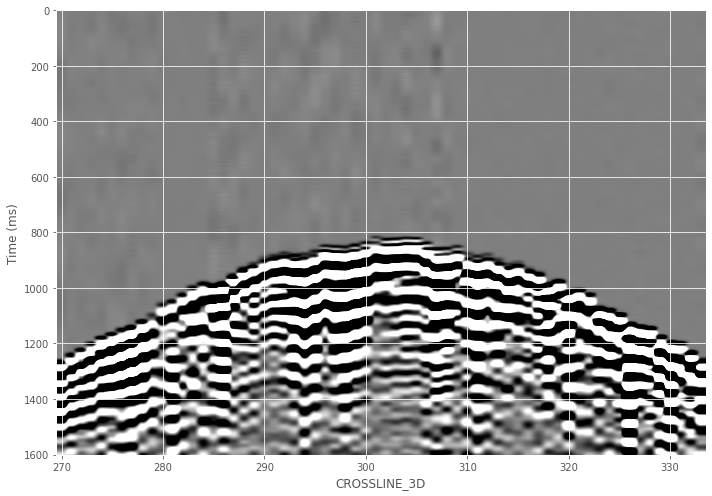

In [270]:
sd.sample_gather().sort(by="CROSSLINE_3D").plot()

In [203]:
%%time
sur_fr = survey.reindex("FieldRecord")

CPU times: user 5.59 s, sys: 2.58 s, total: 8.18 s
Wall time: 8.18 s


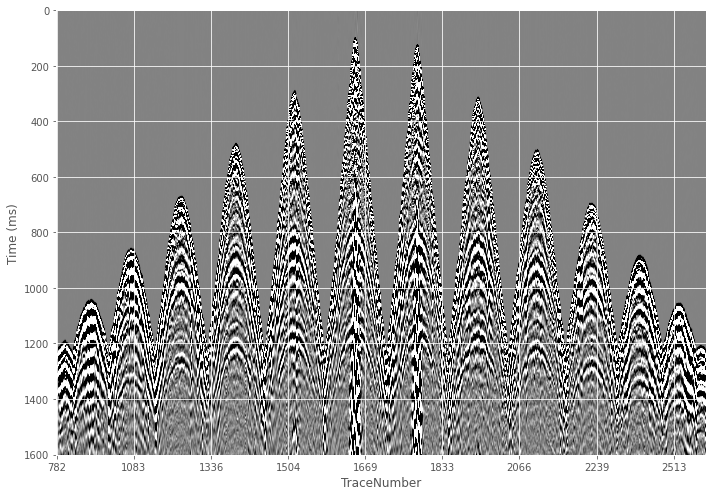

In [219]:
g.sort(by="TraceNumber").plot()

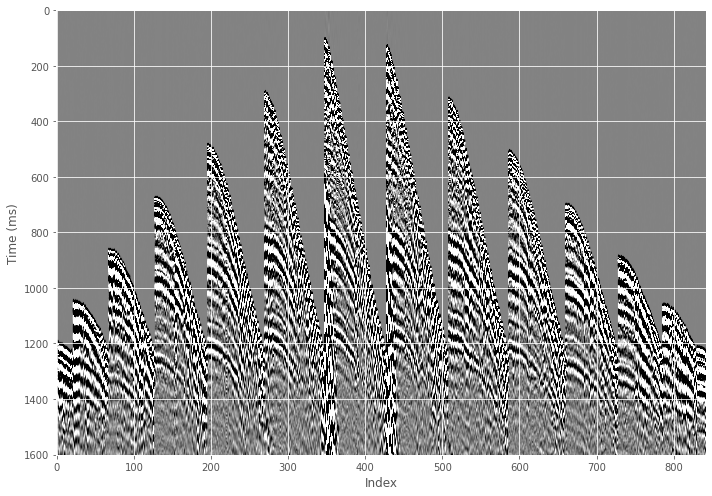

In [218]:
g.plot()

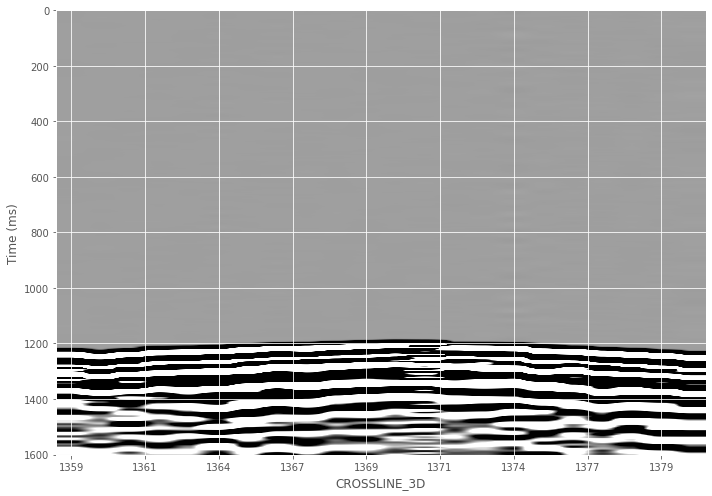

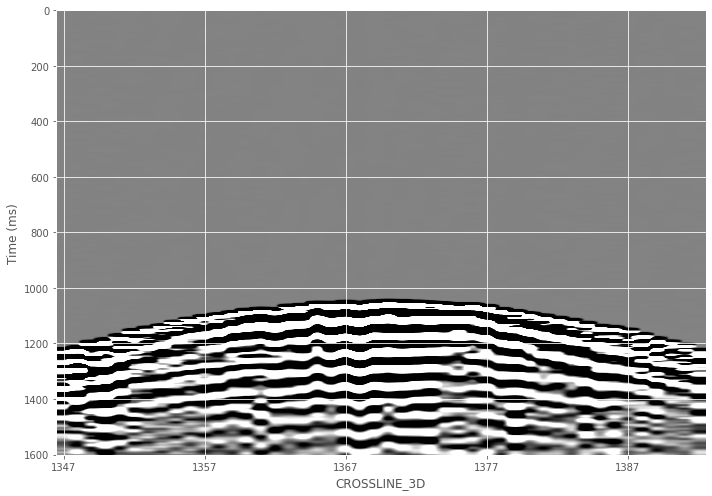

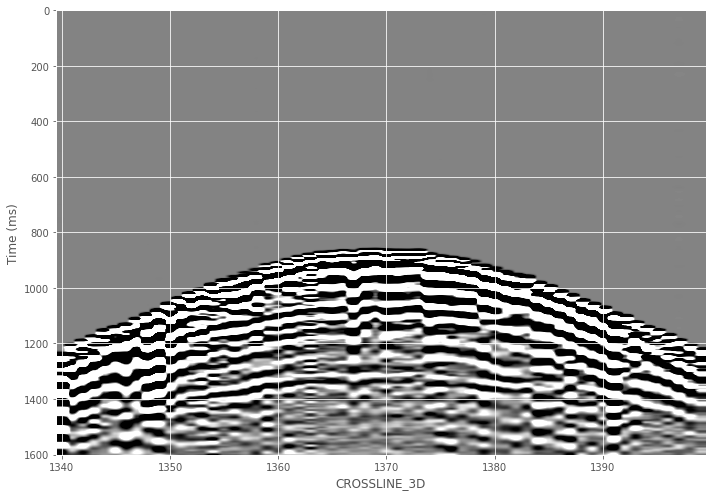

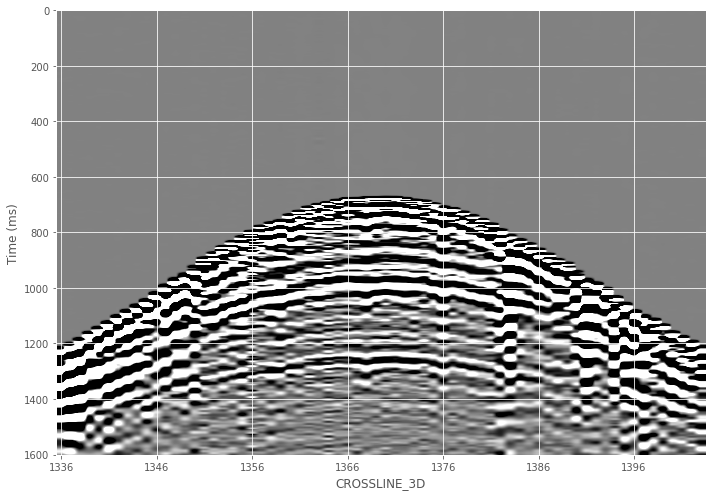

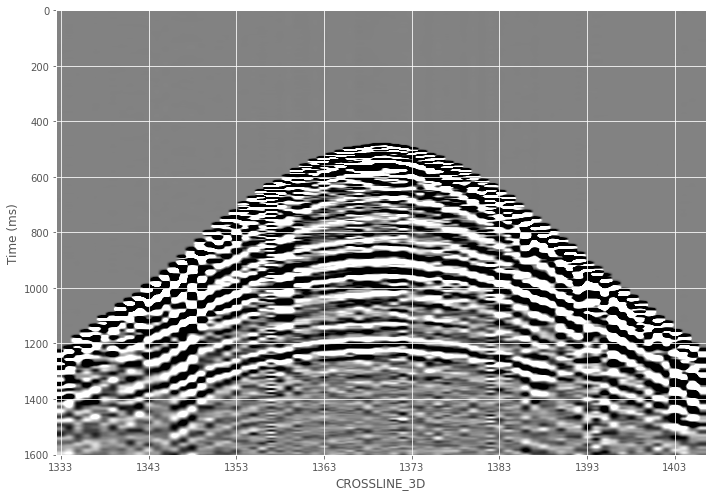

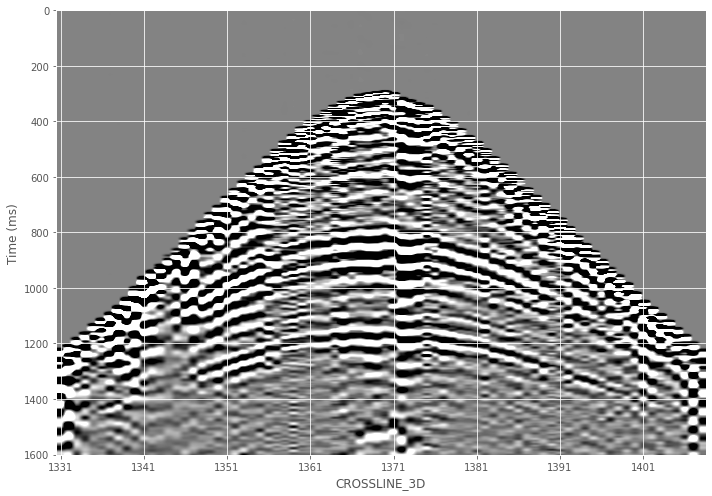

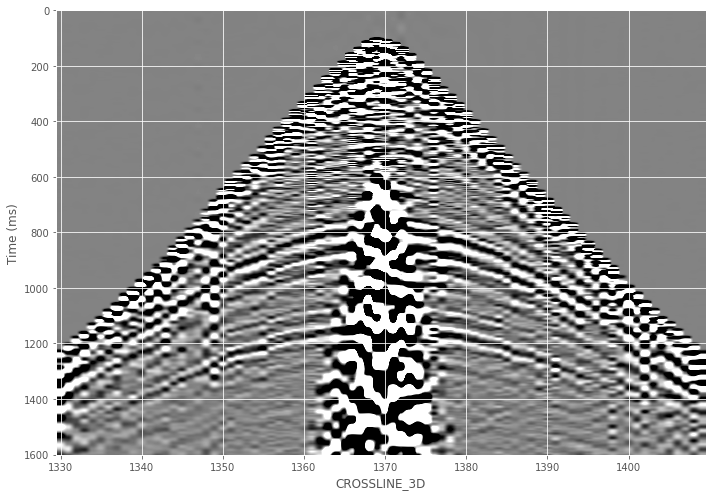

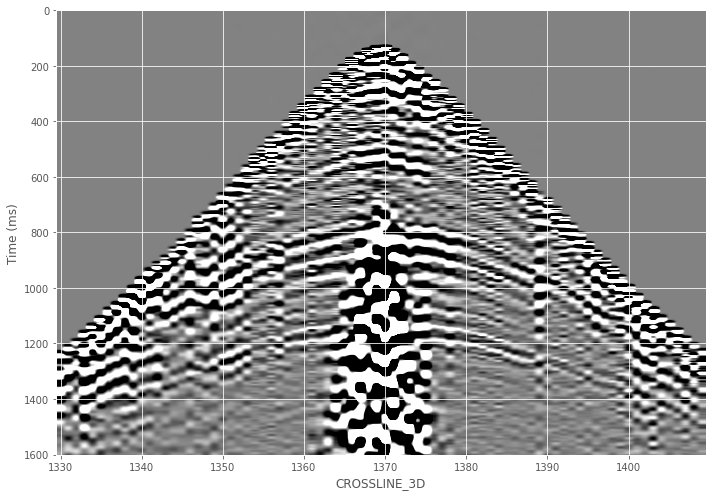

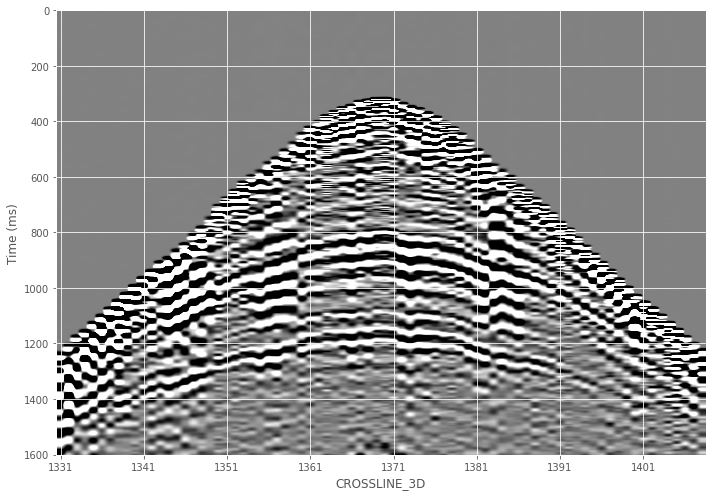

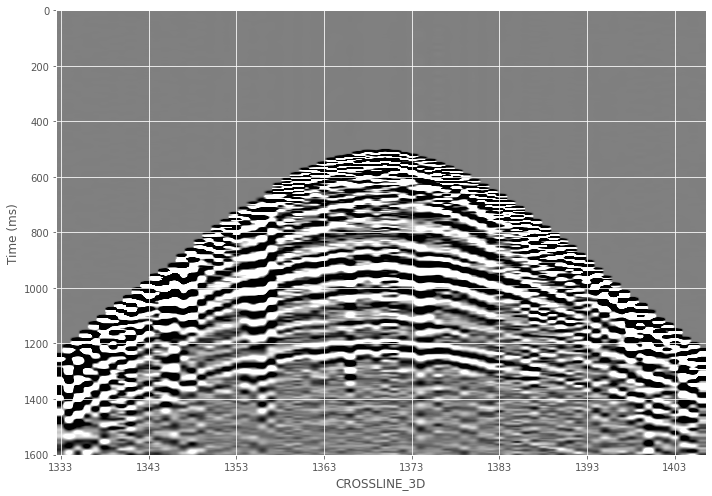

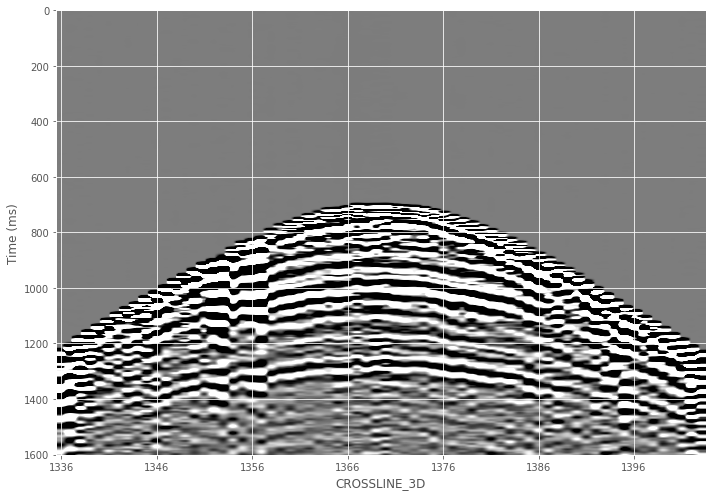

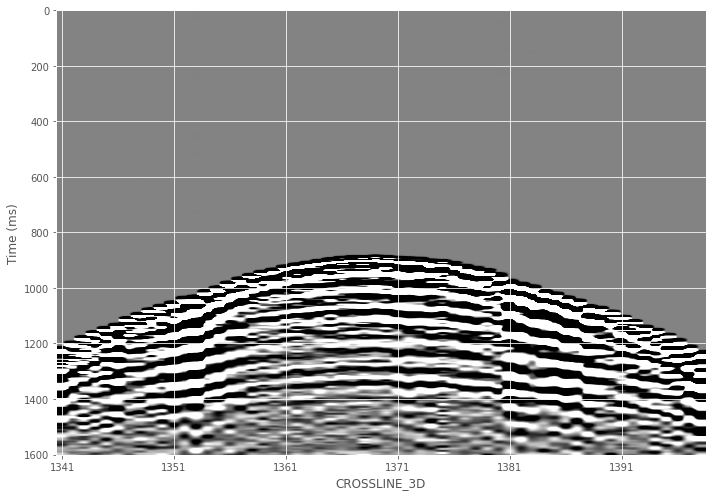

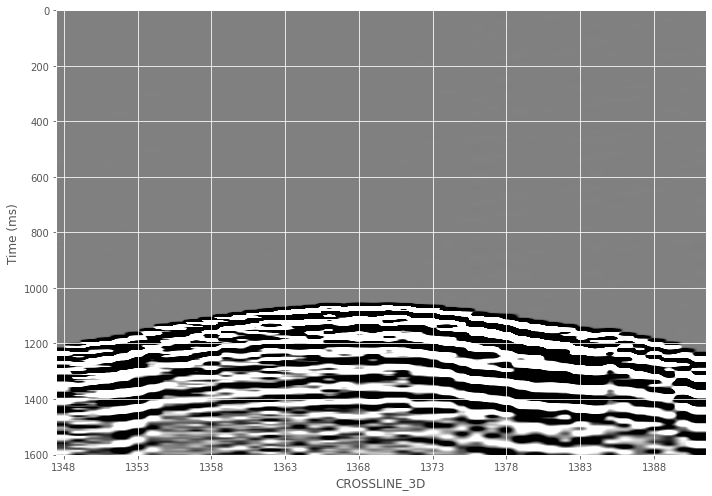

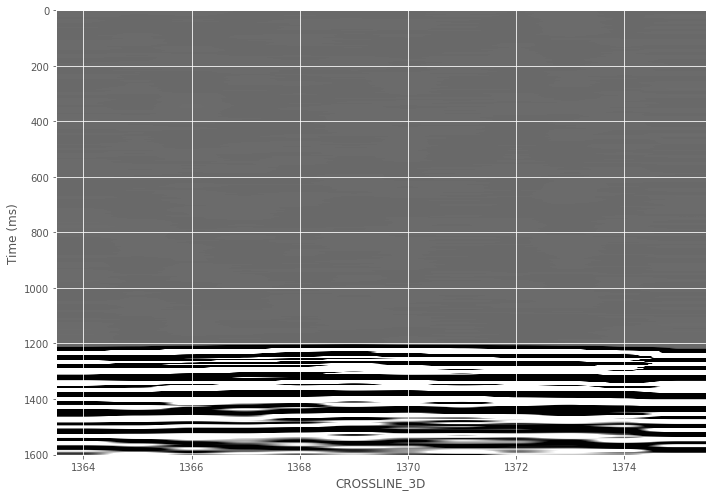

In [217]:
%matplotlib inline
g = sur_fr.sample_gather()
for rl in g.headers["INLINE_3D"].unique():
    gf = g.filter(lambda x: x==rl, cols='INLINE_3D')
    gf.sort(by="CROSSLINE_3D").plot()

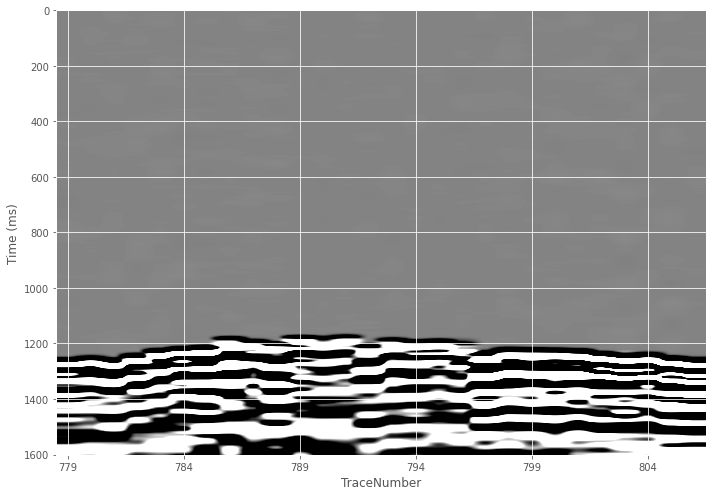

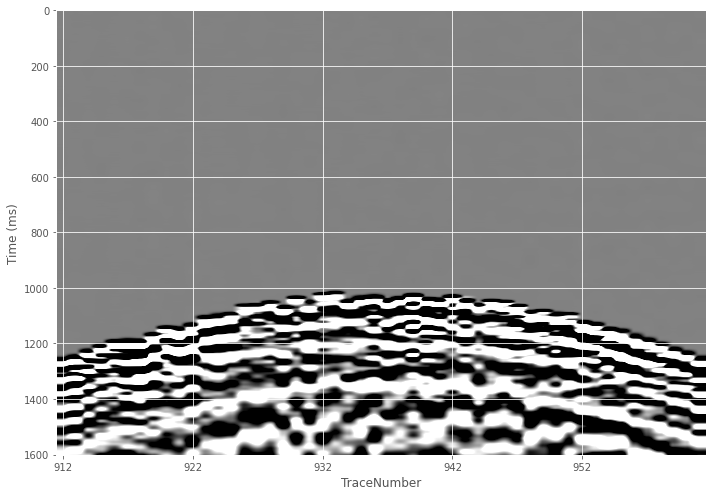

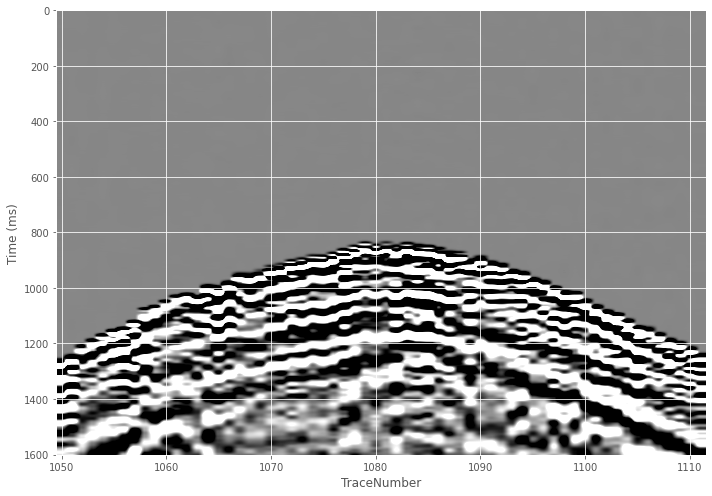

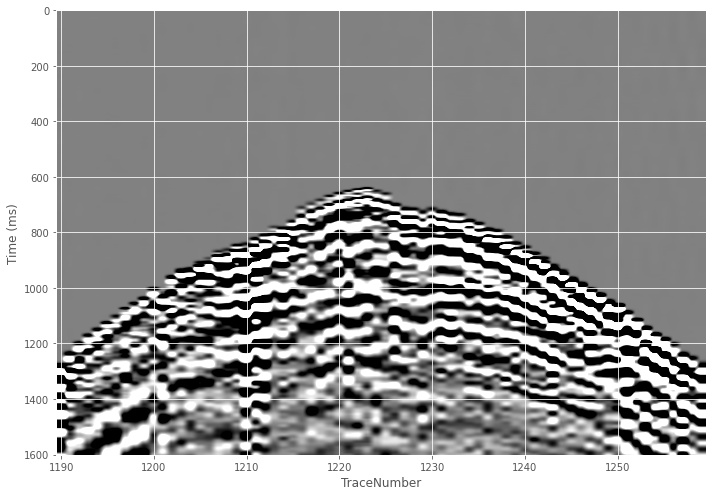

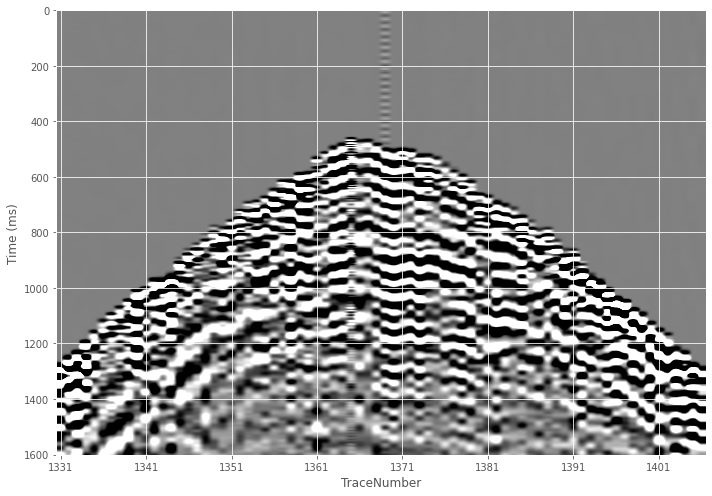

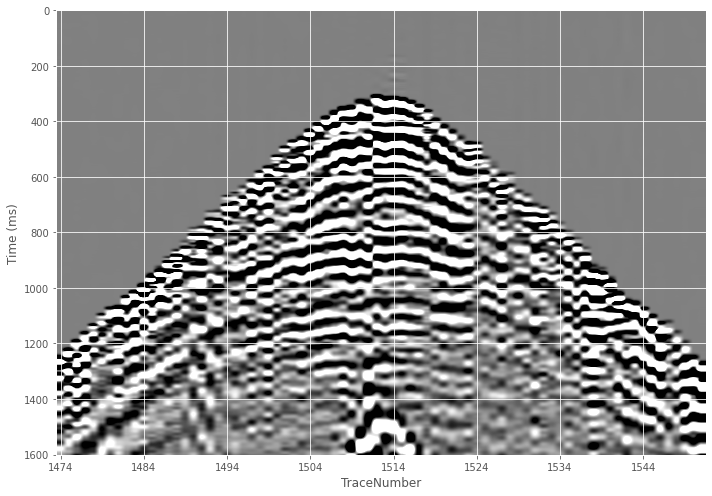

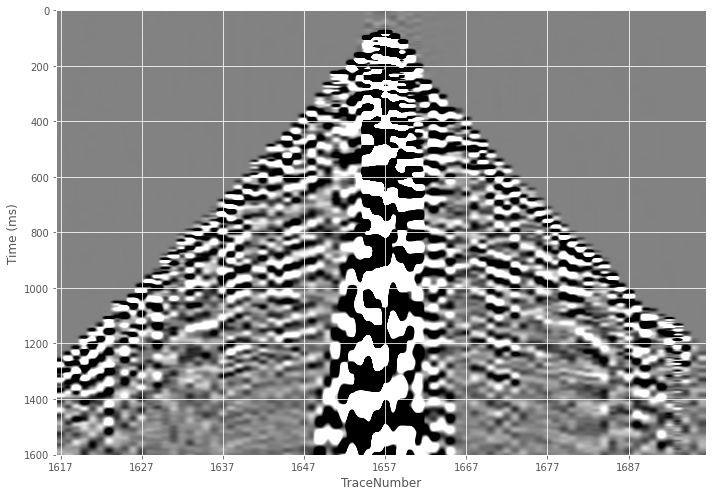

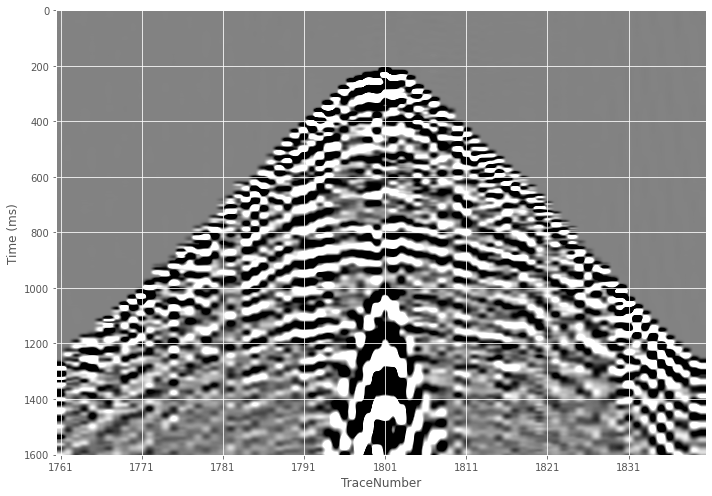

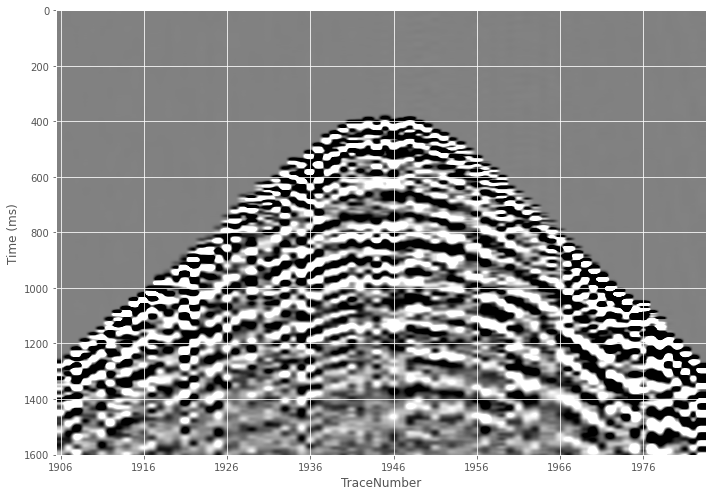

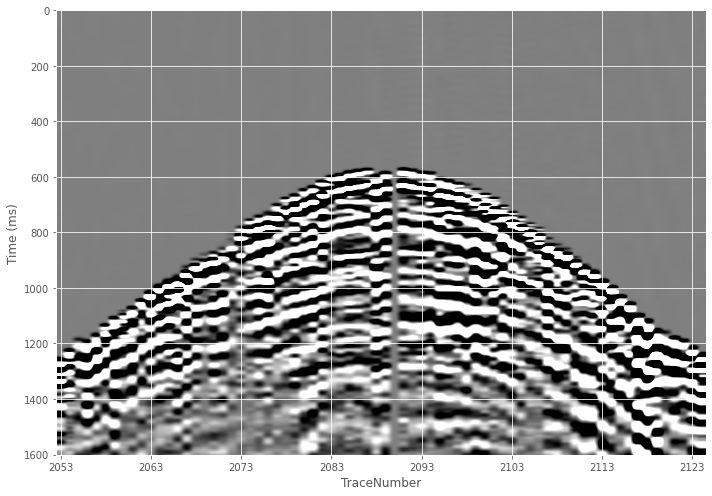

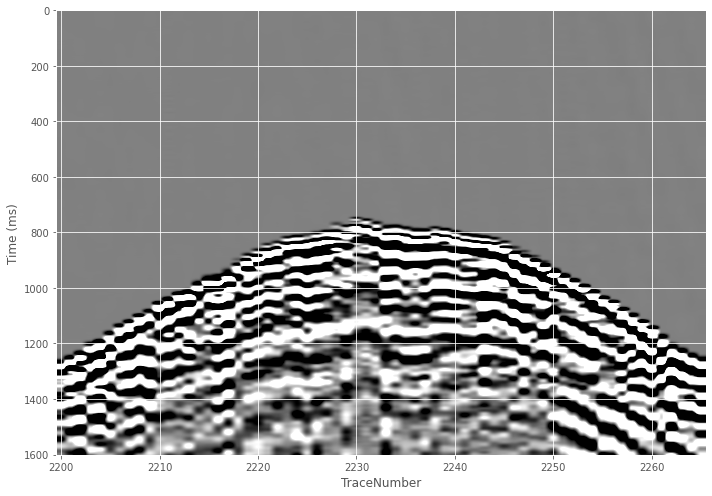

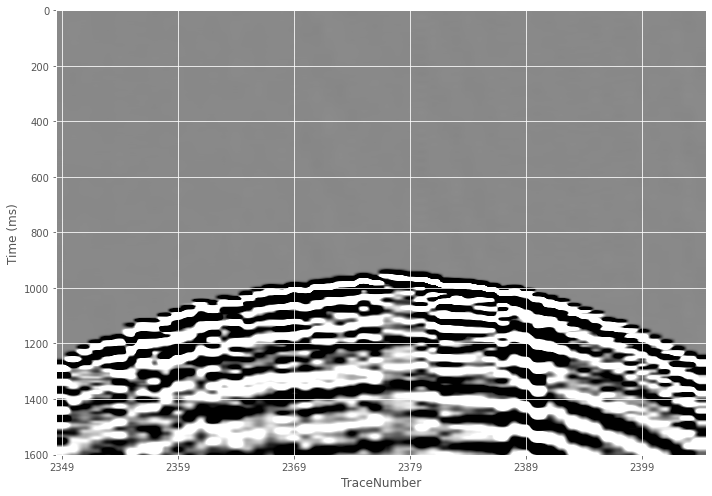

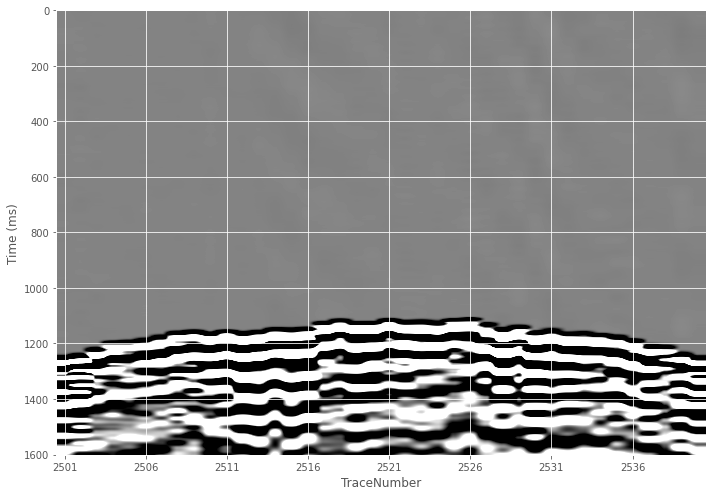

In [216]:
%matplotlib inline
g = sur_fr.sample_gather()
for rl in g.headers.Recline.unique():
    gf = g.filter(lambda x: x==rl, cols='Recline')
    gf.sort(by="TraceNumber").plot()

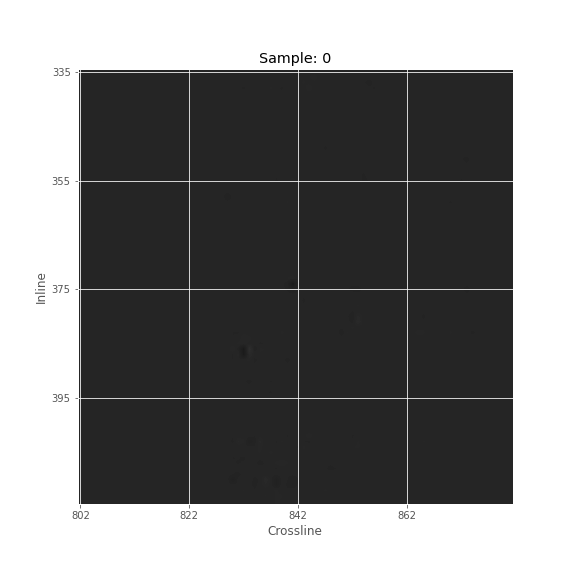

In [202]:
%matplotlib widget

gather_slice_viewer(volume, step=50, q_01=q_01, q_99=q_99, 
                    crosslines=crossline_unique, inlines=inline_unique,
                    first_breaks=first_breaks_3d
                   )

In [60]:
sorted_gather = gather.copy().sort(by='offset')

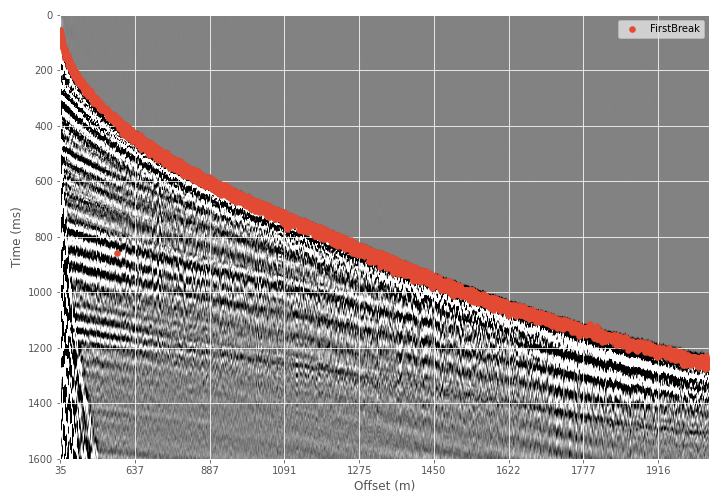

In [61]:
sorted_gather.plot(event_headers='FirstBreak')